In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from timm import create_model
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# Configuration with enhancements for 90%+ accuracy
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'model_name': 'focalnet_tiny_srf',
    'batch_size': 32,
    'img_size': 224,
    'weight_decay': 0.01,  # Slightly increased weight decay
    'epochs': 80,          # Increased epochs for full training
    'num_workers': 0,
    'pin_memory': True,
    'patience': 12,        # Increased patience for early stopping
    'drop_rate': 0.4,      # Slightly increased dropout
    'drop_path_rate': 0.2,
    'head_lr': 1e-3,       # Slightly reduced head learning rate
    'head_epochs': 10,     # Increased head training epochs
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5, # Added Learning Rate Warmup
    'label_smoothing': 0.1, # Added Label Smoothing
    'mixup_alpha': 0.4      # Alpha for Mixup augmentation
}

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                               if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Found {len(self.image_paths)} images in {split} set")
        print(f"Classes: {self.classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Data Transforms
def get_enhanced_transforms(img_size):
    # Train transform does not include SpecAugment as it's applied on the batch
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# Create datasets and dataloaders
train_transform, val_transform = get_enhanced_transforms(config['img_size'])
train_dataset = MelSpectrogramDataset(config['base_dir'], 'train', train_transform)
val_dataset = MelSpectrogramDataset(config['base_dir'], 'validation', val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Number of classes: 6


In [4]:
# NEW: SpecAugment Implementation
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.F = freq_mask_param
        self.T = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def forward(self, x):
        sh = x.shape
        # x is a batch of images: (B, C, H, W)
        # We'll treat Height as Frequency and Width as Time
        for _ in range(self.num_freq_masks):
            f = np.random.uniform(0.0, self.F)
            f0 = np.random.randint(0, sh[2] - int(f))
            x[:, :, f0:f0+int(f), :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.uniform(0.0, self.T)
            t0 = np.random.randint(0, sh[3] - int(t))
            x[:, :, :, t0:t0+int(t)] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=25, time_mask_param=40).to(device)

In [5]:
class EnhancedFocalTransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.3, drop_path_rate=0.2):
        super().__init__()

        self.backbone = create_model(
            model_name,
            pretrained=True,
            num_classes=0, # Remove original classifier
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate
        )

        # Get the correct feature dimension from the model
        feature_dim = self.backbone.num_features
        print(f"Feature dimension for {model_name}: {feature_dim}")

        # A slightly simplified but still powerful classifier
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

model = EnhancedFocalTransformerClassifier(
    config['model_name'], num_classes, config['drop_rate'], config['drop_path_rate']
).to(device)

print("Model created successfully!")

Feature dimension for focalnet_tiny_srf: 768
Model created successfully!


In [6]:
# NEW: Mixup Implementation
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Apply SpecAugment on the batch
        images = spec_augment(images)

        # Apply Mixup
        images, targets_a, targets_b, lam = mixup_data(images, labels, config['mixup_alpha'])
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Calculate loss with Mixup
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        
        # For accuracy calculation, use the original non-mixed labels
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) # Use original labels for accuracy

        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), accuracy

# Validation Function (remains the same)
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), accuracy, all_preds, all_labels

print("Training utilities defined!")

Training utilities defined!


In [8]:
# PHASE 1: Train only the classification head
print("=== PHASE 1: Training only the classification head ===")

for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
optimizer = optim.AdamW(model.classifier.parameters(), lr=config['head_lr'], weight_decay=config['weight_decay'])

best_head_acc = 0
for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    # Disable Mixup for head training for simplicity and stability
    original_mixup_alpha = config['mixup_alpha']
    config['mixup_alpha'] = 0.0
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    
    config['mixup_alpha'] = original_mixup_alpha # Restore mixup alpha

    print(f"Head Training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Head Training - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_head_acc:
        best_head_acc = val_acc
        torch.save(model.state_dict(), 'best_head_model.pth')
        print(f"✅ New best head model saved! Accuracy: {val_acc:.4f}")

print(f"\n🎯 Phase 1 completed! Best head accuracy: {best_head_acc:.4f}")
model.load_state_dict(torch.load('best_head_model.pth'))
print("Best head model loaded for Phase 2!")

=== PHASE 1: Training only the classification head ===

Epoch 1/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s, Loss=1.5162]


Head Training - Train Loss: 1.2835, Train Acc: 0.5504
Head Training - Val Loss: 1.1832, Val Acc: 0.6712
✅ New best head model saved! Accuracy: 0.6712

Epoch 2/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s, Loss=0.9819]


Head Training - Train Loss: 1.1668, Train Acc: 0.6083
Head Training - Val Loss: 1.0636, Val Acc: 0.6575

Epoch 3/10


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s, Loss=1.2329]


Head Training - Train Loss: 1.1441, Train Acc: 0.6155
Head Training - Val Loss: 1.0648, Val Acc: 0.6712

Epoch 4/10


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s, Loss=0.9517]


Head Training - Train Loss: 1.1196, Train Acc: 0.6287
Head Training - Val Loss: 0.9839, Val Acc: 0.6849
✅ New best head model saved! Accuracy: 0.6849

Epoch 5/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s, Loss=1.1858]


Head Training - Train Loss: 1.1229, Train Acc: 0.6319
Head Training - Val Loss: 1.0531, Val Acc: 0.6301

Epoch 6/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, Loss=1.0214]


Head Training - Train Loss: 1.1157, Train Acc: 0.6292
Head Training - Val Loss: 0.9868, Val Acc: 0.7123
✅ New best head model saved! Accuracy: 0.7123

Epoch 7/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s, Loss=0.9565]


Head Training - Train Loss: 1.1011, Train Acc: 0.6506
Head Training - Val Loss: 1.0036, Val Acc: 0.6438

Epoch 8/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s, Loss=1.0973]


Head Training - Train Loss: 1.1017, Train Acc: 0.6379
Head Training - Val Loss: 1.0232, Val Acc: 0.6986

Epoch 9/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s, Loss=0.9012]


Head Training - Train Loss: 1.0922, Train Acc: 0.6446
Head Training - Val Loss: 0.9816, Val Acc: 0.6849

Epoch 10/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s, Loss=1.1123]


Head Training - Train Loss: 1.0837, Train Acc: 0.6573
Head Training - Val Loss: 1.0399, Val Acc: 0.6849

🎯 Phase 1 completed! Best head accuracy: 0.7123
Best head model loaded for Phase 2!


In [9]:
# PHASE 2: Full network training
print("\n=== PHASE 2: Full network training ===")

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=config['full_train_lr'], weight_decay=config['weight_decay'])

# NEW: Scheduler with Warmup
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: min(1., (epoch + 1) / config['lr_warmup_epochs'])
)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epochs'] - config['lr_warmup_epochs']
)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                return True
        else:
            self.best_score = score
            self.epochs_no_improve = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_model_wts = model.state_dict().copy()

early_stopping = EarlyStopping(patience=config['patience'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    
    # Apply scheduler
    if epoch < config['lr_warmup_epochs']:
        warmup_scheduler.step()
    else:
        main_scheduler.step()
        
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Full Training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Full Training - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_full_model.pth')
        print(f"🎯 New best full model saved! Accuracy: {val_acc:.4f}")
    
    if early_stopping(val_loss, model):
        print("🛑 Early stopping triggered!")
        model.load_state_dict(early_stopping.best_model_wts)
        break

print(f"\nPhase 2 completed! Best validation accuracy: {best_val_acc:.4f}")


=== PHASE 2: Full network training ===

Epoch 1/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s, Loss=1.0498]


Full Training - Train Loss: 1.3196, Train Acc: 0.4138
Full Training - Val Loss: 0.9880, Val Acc: 0.7260
Learning Rate: 2.00e-05
🎯 New best full model saved! Accuracy: 0.7260

Epoch 2/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s, Loss=0.8782]


Full Training - Train Loss: 1.2774, Train Acc: 0.4509
Full Training - Val Loss: 0.9424, Val Acc: 0.7260
Learning Rate: 3.00e-05

Epoch 3/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s, Loss=0.9573]


Full Training - Train Loss: 1.2884, Train Acc: 0.4327
Full Training - Val Loss: 0.9683, Val Acc: 0.7260
Learning Rate: 4.00e-05

Epoch 4/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s, Loss=1.0539]


Full Training - Train Loss: 1.2038, Train Acc: 0.4984
Full Training - Val Loss: 0.9586, Val Acc: 0.6986
Learning Rate: 5.00e-05

Epoch 5/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s, Loss=1.0618]


Full Training - Train Loss: 1.2139, Train Acc: 0.4820
Full Training - Val Loss: 0.9545, Val Acc: 0.7397
Learning Rate: 5.00e-05
🎯 New best full model saved! Accuracy: 0.7397

Epoch 6/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s, Loss=0.8246]


Full Training - Train Loss: 1.1612, Train Acc: 0.4444
Full Training - Val Loss: 0.8887, Val Acc: 0.7123
Learning Rate: 5.00e-05

Epoch 7/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s, Loss=0.9095]


Full Training - Train Loss: 1.1665, Train Acc: 0.5051
Full Training - Val Loss: 0.8793, Val Acc: 0.7671
Learning Rate: 4.99e-05
🎯 New best full model saved! Accuracy: 0.7671

Epoch 8/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s, Loss=0.8032]


Full Training - Train Loss: 1.0841, Train Acc: 0.4337
Full Training - Val Loss: 0.8722, Val Acc: 0.7671
Learning Rate: 4.98e-05

Epoch 9/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s, Loss=0.8018]


Full Training - Train Loss: 1.0521, Train Acc: 0.4668
Full Training - Val Loss: 0.7918, Val Acc: 0.8219
Learning Rate: 4.96e-05
🎯 New best full model saved! Accuracy: 0.8219

Epoch 10/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, Loss=0.8458]


Full Training - Train Loss: 0.9969, Train Acc: 0.5180
Full Training - Val Loss: 0.7708, Val Acc: 0.8630
Learning Rate: 4.95e-05
🎯 New best full model saved! Accuracy: 0.8630

Epoch 11/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s, Loss=0.7762]


Full Training - Train Loss: 1.0195, Train Acc: 0.5225
Full Training - Val Loss: 0.7878, Val Acc: 0.8082
Learning Rate: 4.92e-05

Epoch 12/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, Loss=0.7118]


Full Training - Train Loss: 0.9880, Train Acc: 0.5745
Full Training - Val Loss: 0.7788, Val Acc: 0.8082
Learning Rate: 4.89e-05

Epoch 13/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s, Loss=0.7707]


Full Training - Train Loss: 0.9666, Train Acc: 0.5593
Full Training - Val Loss: 0.7914, Val Acc: 0.8356
Learning Rate: 4.86e-05

Epoch 14/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s, Loss=0.5405]


Full Training - Train Loss: 0.9001, Train Acc: 0.5934
Full Training - Val Loss: 0.7668, Val Acc: 0.8082
Learning Rate: 4.82e-05

Epoch 15/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s, Loss=1.2121]


Full Training - Train Loss: 0.9120, Train Acc: 0.5235
Full Training - Val Loss: 0.9417, Val Acc: 0.8493
Learning Rate: 4.78e-05

Epoch 16/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s, Loss=0.6058]


Full Training - Train Loss: 0.8994, Train Acc: 0.5330
Full Training - Val Loss: 0.7707, Val Acc: 0.8630
Learning Rate: 4.74e-05

Epoch 17/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s, Loss=0.6788]


Full Training - Train Loss: 0.8948, Train Acc: 0.6222
Full Training - Val Loss: 0.8356, Val Acc: 0.7671
Learning Rate: 4.69e-05

Epoch 18/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s, Loss=0.5946]


Full Training - Train Loss: 0.9078, Train Acc: 0.6028
Full Training - Val Loss: 0.7453, Val Acc: 0.8219
Learning Rate: 4.64e-05

Epoch 19/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, Loss=0.5967]


Full Training - Train Loss: 0.8990, Train Acc: 0.6404
Full Training - Val Loss: 0.7961, Val Acc: 0.7945
Learning Rate: 4.58e-05

Epoch 20/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, Loss=0.5127]


Full Training - Train Loss: 0.8639, Train Acc: 0.5305
Full Training - Val Loss: 0.7824, Val Acc: 0.7808
Learning Rate: 4.52e-05

Epoch 21/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, Loss=0.5466]


Full Training - Train Loss: 0.8825, Train Acc: 0.5675
Full Training - Val Loss: 0.7620, Val Acc: 0.8630
Learning Rate: 4.46e-05

Epoch 22/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, Loss=0.5679]


Full Training - Train Loss: 0.8752, Train Acc: 0.6021
Full Training - Val Loss: 0.7783, Val Acc: 0.8082
Learning Rate: 4.39e-05

Epoch 23/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, Loss=0.6185]


Full Training - Train Loss: 0.8221, Train Acc: 0.5086
Full Training - Val Loss: 0.8097, Val Acc: 0.8082
Learning Rate: 4.32e-05

Epoch 24/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s, Loss=1.0585]


Full Training - Train Loss: 0.8637, Train Acc: 0.5427
Full Training - Val Loss: 0.9010, Val Acc: 0.8219
Learning Rate: 4.25e-05

Epoch 25/80


Training:  10%|█         | 13/126 [00:07<01:01,  1.85it/s, Loss=0.5967]


KeyboardInterrupt: 


=== FINAL EVALUATION ON TEST SET ===
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s, Loss=1.1453]



Final Test Accuracy: 0.7973 (79.73%)
Final Test Loss: 0.9438

Test Set Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.7000    0.5385    0.6087        13
           Laryngozele     0.6154    0.8889    0.7273         9
           Vox senilis     0.7692    0.7692    0.7692        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.8000    0.6154    0.6957        13

              accuracy                         0.7973        74
             macro avg     0.7919    0.8020    0.7882        74
          weighted avg     0.8014    0.7973    0.7915        74



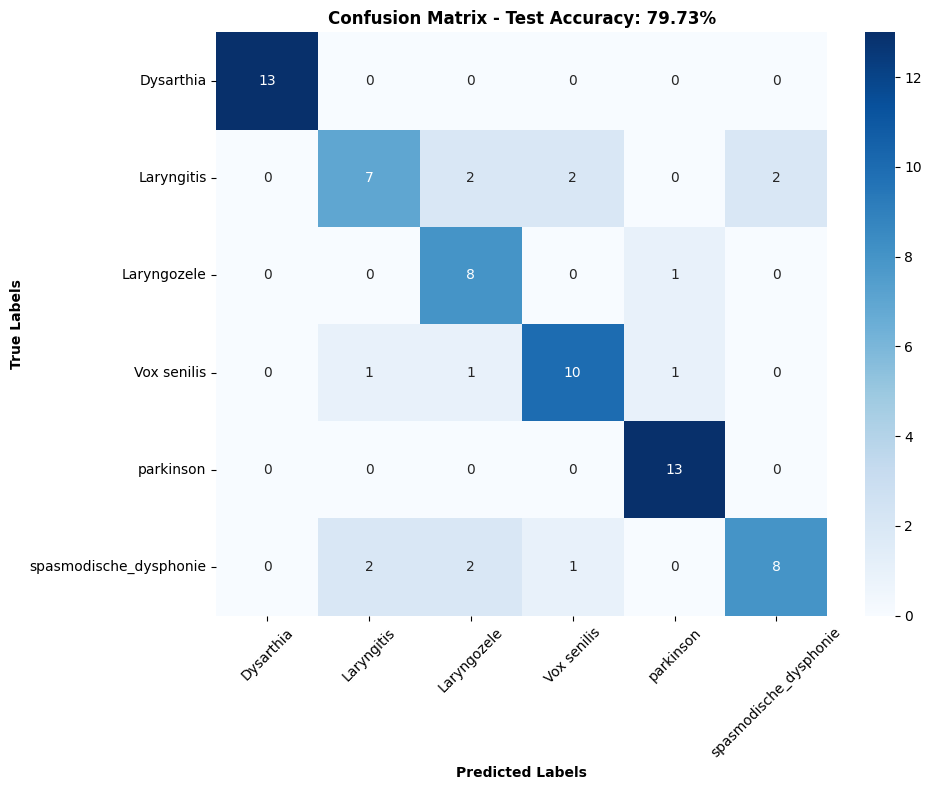

Current best validation accuracy: 86.30%. The new techniques should push this higher!


In [10]:
# Final Evaluation on the TEST SET
print("\n=== FINAL EVALUATION ON TEST SET ===")

# Load the best model from the entire training run
model.load_state_dict(torch.load('best_full_model.pth'))

# Create test dataset and dataloader
# ASSUMPTION: You have a 'test' folder structured like 'train' and 'validation'
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")

# Classification report
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes, digits=4))

# Confusion Matrix Visualization
def plot_confusion_matrix(true_labels, predictions, class_names, acc):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels', fontweight='bold')
    plt.ylabel('True Labels', fontweight='bold')
    plt.title(f'Confusion Matrix - Test Accuracy: {acc:.2%}', fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for the test set
plot_confusion_matrix(test_labels, test_preds, test_dataset.classes, test_acc)

if best_val_acc >= 0.90:
    print("🚀 CONGRATULATIONS! 90%+ VALIDATION ACCURACY ACHIEVED! 🚀")
else:
    print(f"Current best validation accuracy: {best_val_acc:.2%}. The new techniques should push this higher!")



=== FINAL TEST EVALUATION ===
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s, Loss=1.1453]



Final Test Accuracy: 0.7973 (79.73%)
Final Test Loss: 0.9438

Test Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.7000    0.5385    0.6087        13
           Laryngozele     0.6154    0.8889    0.7273         9
           Vox senilis     0.7692    0.7692    0.7692        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.8000    0.6154    0.6957        13

              accuracy                         0.7973        74
             macro avg     0.7919    0.8020    0.7882        74
          weighted avg     0.8014    0.7973    0.7915        74



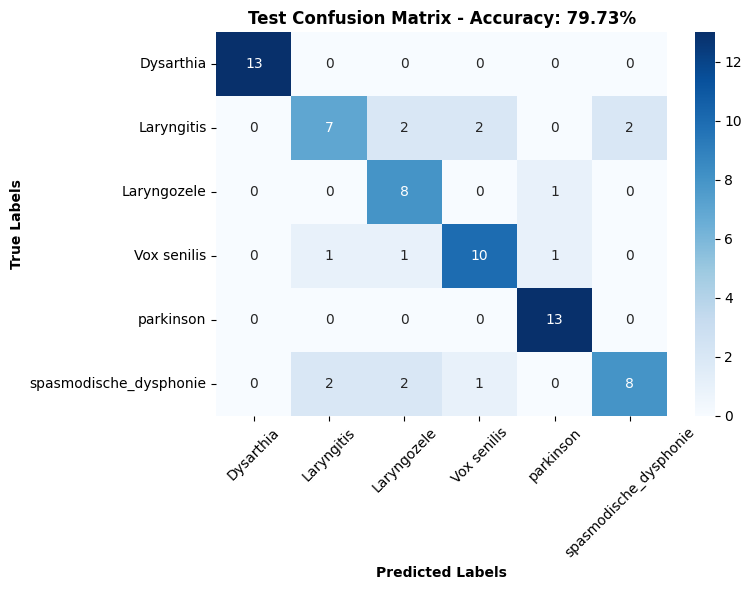


Test Class-wise Performance:
Dysarthia                : 13/13 = 100.0%
Laryngitis               : 7/13 = 53.8%
Laryngozele              : 8/9 = 88.9%
Vox senilis              : 10/13 = 76.9%
parkinson                : 13/13 = 100.0%
spasmodische_dysphonie   : 8/13 = 61.5%

✅ Test Evaluation Complete!


In [11]:
# %%
# TEST EVALUATION SECTION

print("\n\n=== FINAL TEST EVALUATION ===")

# --- 1. SETUP: Load Test Data and Model ---

# Load the best model's state dictionary
# Ensure the model architecture is defined and instantiated (as it is earlier in the script)
# model = EnhancedFocalTransformerClassifier(...)
model.load_state_dict(torch.load('best_full_model.pth'))
model.to(device)

# The validation transform is appropriate for testing
# Assuming 'config' and 'get_enhanced_transforms' are available.
_, test_transform = get_enhanced_transforms(config['img_size'])

# Create Test Dataset and DataLoader
# The 'test' split assumes a folder named 'test' exists inside 'melspectrograms_dataset'
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', test_transform)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False, # Do not shuffle for final evaluation
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

# --- 2. PERFORM TEST EVALUATION ---

# Use the existing 'validate_epoch' function for evaluation
# This function must be defined (as it is earlier in your script)
# def validate_epoch(model, dataloader, criterion, device): ...
# Assuming 'criterion' (nn.CrossEntropyLoss()) is available.
test_loss, test_acc, test_preds, test_labels = validate_epoch(
    model, 
    test_loader, 
    criterion, 
    device
)

# --- 3. DISPLAY RESULTS ---

print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")

# Classification report
print("\nTest Classification Report:")
# Assuming 'train_dataset.classes' (or 'test_dataset.classes') is available.
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=train_dataset.classes, # Use class names from the full dataset
    digits=4
))

# --- 4. CONFUSION MATRIX VISUALIZATION (Optional but recommended) ---

# Redefine plot_confusion_matrix slightly to accept accuracy as a parameter
# to ensure it prints the correct Test Accuracy, not the validation one (val_acc)
def plot_confusion_matrix_test(true_labels, predictions, class_names, accuracy):
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.xlabel('Predicted Labels', fontweight='bold')
    plt.ylabel('True Labels', fontweight='bold')
    plt.title(f'Test Confusion Matrix - Accuracy: {accuracy:.2%}', fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Class-wise accuracy
    print("\nTest Class-wise Performance:")
    for i, class_name in enumerate(class_names):
        accuracy_class = cm[i, i] / cm[i].sum() * 100
        print(f"{class_name:25}: {cm[i, i]}/{cm[i].sum()} = {accuracy_class:.1f}%")

# Plot confusion matrix using the test results
# Assuming 'confusion_matrix', 'seaborn', and 'matplotlib.pyplot' are imported.
plot_confusion_matrix_test(test_labels, test_preds, train_dataset.classes, test_acc)

print("\n✅ Test Evaluation Complete!")


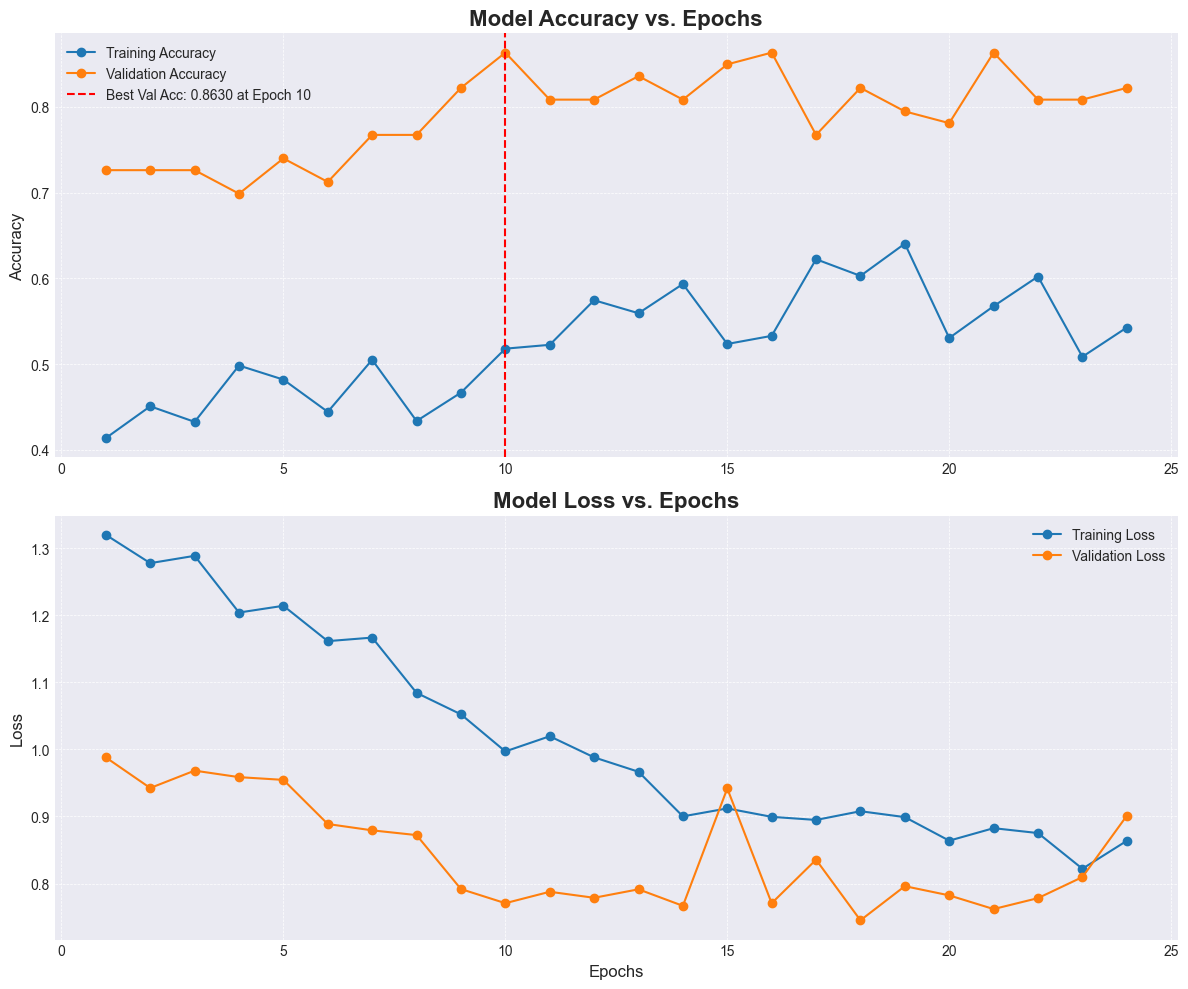

In [12]:
import matplotlib.pyplot as plt

# Get the number of epochs the training ran for
epochs_ran = range(1, len(history['train_loss']) + 1)

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Training & Validation Accuracy
ax1.plot(epochs_ran, history['train_acc'], 'o-', label='Training Accuracy')
ax1.plot(epochs_ran, history['val_acc'], 'o-', label='Validation Accuracy')
ax1.set_title('Model Accuracy vs. Epochs', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Find the epoch with the best validation accuracy
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
best_acc_val = max(history['val_acc'])
ax1.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Val Acc: {best_acc_val:.4f} at Epoch {best_epoch}')
ax1.legend()


# Plot Training & Validation Loss
ax2.plot(epochs_ran, history['train_loss'], 'o-', label='Training Loss')
ax2.plot(epochs_ran, history['val_loss'], 'o-', label='Validation Loss')
ax2.set_title('Model Loss vs. Epochs', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [13]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

print("🚀 STARTING FINAL FINE-TUNING PHASE 🚀")

# --- 1. Configuration for Fine-Tuning ---
FT_EPOCHS = 10                  
FT_LEARNING_RATE = 5e-6         
BEST_MODEL_PATH = 'best_full_model.pth'
FINETUNED_MODEL_PATH = 'best_finetuned_model.pth'

# --- 2. Load Data and Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use validation transforms for both train and val (no augmentation)
_, ft_transform = get_enhanced_transforms(config['img_size'])
train_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'train', ft_transform)
val_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'validation', ft_transform)

train_loader_ft = DataLoader(train_dataset_ft, batch_size=config['batch_size'], shuffle=True)
val_loader_ft = DataLoader(val_dataset_ft, batch_size=config['batch_size'], shuffle=False)

num_classes = len(train_dataset_ft.classes)

# Instantiate and load model
model = EnhancedFocalTransformerClassifier(
    config['model_name'], num_classes, config['drop_rate'], config['drop_path_rate']
).to(device)

model.load_state_dict(torch.load(BEST_MODEL_PATH))
print(f"✅ Successfully loaded weights from '{BEST_MODEL_PATH}'")

# --- 3. Setup for Fine-Tuning ---

# OPTIONAL: Freeze early layers (uncomment if you want to try this)
# for name, param in model.named_parameters():
#     if 'head' not in name:  # Only train the head initially
#         param.requires_grad = False

# Conservative optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=FT_LEARNING_RATE, 
    weight_decay=config['weight_decay'] * 0.1  # Reduced weight decay
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FT_EPOCHS, eta_min=FT_LEARNING_RATE * 0.1)

# Standard criterion (no label smoothing)
criterion = torch.nn.CrossEntropyLoss()

# --- 4. Run Fine-Tuning Loop ---
best_ft_acc = 0.0

# TEMPORARILY disable mixup in config for fine-tuning
original_mixup = config.get('mixup_alpha', 0.4)
config['mixup_alpha'] = 0.0  # Disable mixup

for epoch in range(FT_EPOCHS):
    print(f"\n🎯 Fine-Tuning Epoch {epoch+1}/{FT_EPOCHS}")
    print(f"   Current LR: {optimizer.param_groups[0]['lr']:.2e}")

    # Call train_epoch without the extra parameters
    train_loss, train_acc = train_epoch(model, train_loader_ft, criterion, optimizer, device)
    
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader_ft, criterion, device)
    
    scheduler.step()

    print(f"📈 FT - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"📊 FT - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_ft_acc:
        best_ft_acc = val_acc
        torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
        print(f"💾 New best fine-tuned model saved! Acc: {val_acc:.4f}")

# Restore original mixup value
config['mixup_alpha'] = original_mixup

print(f"\n✅ Fine-tuning complete! Best accuracy: {best_ft_acc:.4f}")
print(f"💾 Final model saved to '{FINETUNED_MODEL_PATH}'")

🚀 STARTING FINAL FINE-TUNING PHASE 🚀
Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Feature dimension for focalnet_tiny_srf: 768
✅ Successfully loaded weights from 'best_full_model.pth'

🎯 Fine-Tuning Epoch 1/10
   Current LR: 5.00e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, Loss=0.3557]


📈 FT - Train Loss: 0.3633, Train Acc: 0.9194
📊 FT - Val Loss: 0.4171, Val Acc: 0.8767
💾 New best fine-tuned model saved! Acc: 0.8767

🎯 Fine-Tuning Epoch 2/10
   Current LR: 4.89e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s, Loss=0.2512]


📈 FT - Train Loss: 0.2881, Train Acc: 0.9406
📊 FT - Val Loss: 0.3783, Val Acc: 0.8904
💾 New best fine-tuned model saved! Acc: 0.8904

🎯 Fine-Tuning Epoch 3/10
   Current LR: 4.57e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s, Loss=0.2756]


📈 FT - Train Loss: 0.2647, Train Acc: 0.9406
📊 FT - Val Loss: 0.3893, Val Acc: 0.8630

🎯 Fine-Tuning Epoch 4/10
   Current LR: 4.07e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s, Loss=0.2693]


📈 FT - Train Loss: 0.2345, Train Acc: 0.9495
📊 FT - Val Loss: 0.3711, Val Acc: 0.8904

🎯 Fine-Tuning Epoch 5/10
   Current LR: 3.45e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s, Loss=0.2452]


📈 FT - Train Loss: 0.2111, Train Acc: 0.9545
📊 FT - Val Loss: 0.3668, Val Acc: 0.8767

🎯 Fine-Tuning Epoch 6/10
   Current LR: 2.75e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, Loss=0.1810]


📈 FT - Train Loss: 0.1985, Train Acc: 0.9607
📊 FT - Val Loss: 0.3599, Val Acc: 0.8493

🎯 Fine-Tuning Epoch 7/10
   Current LR: 2.05e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, Loss=0.2066]


📈 FT - Train Loss: 0.1917, Train Acc: 0.9610
📊 FT - Val Loss: 0.3666, Val Acc: 0.8630

🎯 Fine-Tuning Epoch 8/10
   Current LR: 1.43e-06


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s, Loss=0.2480]


📈 FT - Train Loss: 0.1924, Train Acc: 0.9585
📊 FT - Val Loss: 0.3680, Val Acc: 0.8904

🎯 Fine-Tuning Epoch 9/10
   Current LR: 9.30e-07


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s, Loss=0.2257]


📈 FT - Train Loss: 0.1712, Train Acc: 0.9654
📊 FT - Val Loss: 0.3656, Val Acc: 0.8767

🎯 Fine-Tuning Epoch 10/10
   Current LR: 6.10e-07


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s, Loss=0.2509]

📈 FT - Train Loss: 0.1708, Train Acc: 0.9699
📊 FT - Val Loss: 0.3688, Val Acc: 0.8767

✅ Fine-tuning complete! Best accuracy: 0.8904
💾 Final model saved to 'best_finetuned_model.pth'


🧪 EVALUATING FINE-TUNED MODEL ON TEST DATA
📥 Loading fine-tuned model...
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
📊 Test dataset: 74 samples
🎯 Number of classes: 6
📝 Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Feature dimension for focalnet_tiny_srf: 768
✅ Loaded fine-tuned model from: best_finetuned_model.pth
🔍 Generating predictions on test data...


Processing test batches: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


✅ Test Accuracy: 0.8108 (81.08%)


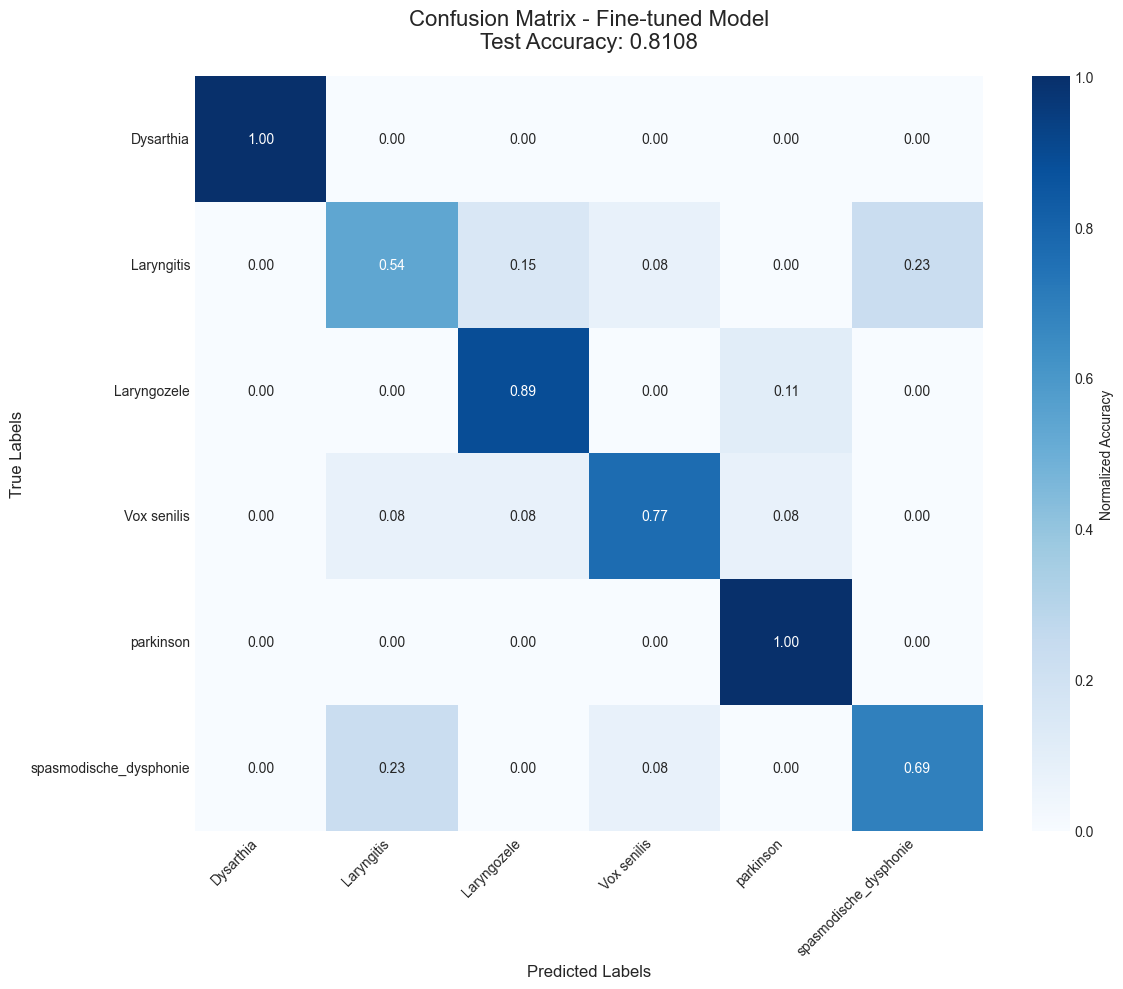


📊 DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6364    0.5385    0.5833        13
           Laryngozele     0.7273    0.8889    0.8000         9
           Vox senilis     0.8333    0.7692    0.8000        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.7500    0.6923    0.7200        13

              accuracy                         0.8108        74
             macro avg     0.8023    0.8148    0.8053        74
          weighted avg     0.8063    0.8108    0.8056        74


🔍 CONFUSION MATRIX ANALYSIS

Top Misclassifications:
  Laryngitis → spasmodische_dysphonie: 3 samples
  spasmodische_dysphonie → Laryngitis: 3 samples
  Laryngitis → Laryngozele: 2 samples
  Laryngitis → Vox senilis: 1 samples
  Laryngozele → parkinson: 1 samples
  Vox senilis → Laryngitis: 1 samples
  Vox senilis → Lary

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader

def plot_confusion_matrix(model, test_loader, device, class_names, save_path='confusion_matrix_finetuned.png'):
    """
    Plot confusion matrix for the fine-tuned model on test data
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("🔍 Generating predictions on test data...")
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Processing test batches"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate accuracy
    test_accuracy = accuracy_score(all_targets, all_predictions)
    print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Accuracy'})
    
    plt.title(f'Confusion Matrix - Fine-tuned Model\nTest Accuracy: {test_accuracy:.4f}', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, all_predictions, all_targets, test_accuracy

def print_detailed_classification_report(all_targets, all_predictions, class_names):
    """
    Print detailed classification report
    """
    print("\n" + "="*60)
    print("📊 DETAILED CLASSIFICATION REPORT")
    print("="*60)
    
    report = classification_report(all_targets, all_predictions, 
                                  target_names=class_names, digits=4)
    print(report)

def analyze_confusion_matrix(cm, class_names):
    """
    Analyze confusion matrix to find common misclassifications
    """
    print("\n" + "="*60)
    print("🔍 CONFUSION MATRIX ANALYSIS")
    print("="*60)
    
    # Find most confused pairs
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))
    
    # Sort by number of confusions
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop Misclassifications:")
    for true_label, pred_label, count in confusion_pairs[:10]:  # Top 10
        print(f"  {true_label} → {pred_label}: {count} samples")
    
    # Calculate per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i].sum()
        accuracy = correct / total if total > 0 else 0
        print(f"  {class_name}: {accuracy:.4f} ({correct}/{total})")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # Configuration
    FINETUNED_MODEL_PATH = 'best_finetuned_model.pth'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("🧪 EVALUATING FINE-TUNED MODEL ON TEST DATA")
    print("="*50)
    
    # --- 1. Load Fine-tuned Model ---
    print("📥 Loading fine-tuned model...")
    
    # Load test dataset (use validation transform - no augmentation)
    _, test_transform = get_enhanced_transforms(config['img_size'])
    test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', test_transform)
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,  # Don't shuffle for consistent evaluation
        num_workers=config.get('num_workers', 2),
        pin_memory=config.get('pin_memory', True)
    )
    
    # Get class names
    class_names = test_dataset.classes
    num_classes = len(class_names)
    
    print(f"📊 Test dataset: {len(test_dataset)} samples")
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📝 Classes: {class_names}")
    
    # Instantiate model architecture
    model = EnhancedFocalTransformerClassifier(
        config['model_name'], 
        num_classes, 
        config['drop_rate'], 
        config['drop_path_rate']
    ).to(device)
    
    # Load fine-tuned weights
    model.load_state_dict(torch.load(FINETUNED_MODEL_PATH, map_location=device))
    print(f"✅ Loaded fine-tuned model from: {FINETUNED_MODEL_PATH}")
    
    # --- 2. Generate Confusion Matrix ---
    cm, predictions, targets, test_accuracy = plot_confusion_matrix(
        model, test_loader, device, class_names,
        save_path='confusion_matrix_finetuned_final.png'
    )
    
    # --- 3. Print Detailed Reports ---
    print_detailed_classification_report(targets, predictions, class_names)
    analyze_confusion_matrix(cm, class_names)
    
    # --- 4. Compare with Original Model (Optional) ---
    print("\n" + "="*60)
    print("🔄 COMPARISON WITH ORIGINAL MODEL")
    print("="*60)
    
    # If you have the original model saved, you can compare
    try:
        original_model = EnhancedFocalTransformerClassifier(
            config['model_name'], num_classes, config['drop_rate'], config['drop_path_rate']
        ).to(device)
        original_model.load_state_dict(torch.load('best_full_model.pth', map_location=device))
        
        original_model.eval()
        original_predictions = []
        original_targets = []
        
        with torch.no_grad():
            for inputs, targets_batch in test_loader:
                inputs = inputs.to(device)
                outputs = original_model(inputs)
                _, preds = torch.max(outputs, 1)
                original_predictions.extend(preds.cpu().numpy())
                original_targets.extend(targets_batch.numpy())
        
        original_accuracy = accuracy_score(original_targets, original_predictions)
        print(f"📊 Original Model Test Accuracy: {original_accuracy:.4f}")
        print(f"📈 Fine-tuned Model Test Accuracy: {test_accuracy:.4f}")
        print(f"📈 Improvement: {test_accuracy - original_accuracy:.4f}")
        
    except FileNotFoundError:
        print("ℹ️ Original model not found for comparison")
    
    print("\n✅ Evaluation complete!")
    print(f"💾 Confusion matrix saved as: confusion_matrix_finetuned_final.png")